# Personal Mental Health Analysis

This notebook analyzes personal messages to understand mental health patterns, emotional well-being, and life events impact. We'll analyze:
- Daily and weekly emotional patterns
- Activity impact on mood
- Communication patterns across different groups
- Location-based mood analysis
- Overall emotional well-being trends

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for better visualizations
plt.style.use('default')
sns.set_theme()

# Load the personal messages data
df = pd.read_csv('../data/personal_messages_sample.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Display basic information about the dataset
print("Dataset Overview:")
print("-----------------")
print(f"Time period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total messages: {len(df)}")
print("\nUnique values in each category:")
for col in ['recipient_type', 'location', 'app', 'mood_logged', 'activity', 'life_event']:
    print(f"\n{col.title()}:")
    print(df[col].value_counts())

Dataset Overview:
-----------------
Time period: 2025-09-01 07:30:00 to 2025-09-07 20:15:00
Total messages: 27

Unique values in each category:

Recipient_Type:
recipient_type
friend        8
self          8
family        7
work          2
healthcare    2
Name: count, dtype: int64

Location:
location
home        12
office      11
gym          2
commute      1
outdoors     1
Name: count, dtype: int64

App:
app
WhatsApp    12
Notes        8
SMS          5
Slack        2
Name: count, dtype: int64

Mood_Logged:
mood_logged
anxious         3
overwhelmed     2
peaceful        2
happy           2
stressed        1
frustrated      1
energized       1
exhausted       1
down            1
grateful        1
guilty          1
excited         1
unwell          1
sad             1
loving          1
accomplished    1
ecstatic        1
conflicted      1
worried         1
hopeful         1
content         1
determined      1
Name: count, dtype: int64

Activity:
activity
working            9
morning rout

In [4]:
# Function to map moods to five universal emotions
def categorize_universal_emotion(mood):
    # Mapping of moods to universal emotions
    emotion_mapping = {
        'Joy': ['happy', 'excited', 'ecstatic', 'peaceful', 'accomplished', 'grateful', 
                'energized', 'content', 'determined', 'loving'],
        'Sadness': ['sad', 'down', 'exhausted', 'guilty', 'overwhelmed'],
        'Fear': ['anxious', 'worried', 'stressed', 'unwell'],
        'Anger': ['frustrated', 'conflicted'],
        'Disgust': []  # No direct mappings in our current moods
    }
    
    # Find which universal emotion contains this mood
    for emotion, moods in emotion_mapping.items():
        if mood.lower() in moods:
            return emotion
    return 'Other'  # For any moods that don't fit the main categories

# Add universal emotion category to the dataframe
df['universal_emotion'] = df['mood_logged'].apply(categorize_universal_emotion)

# Display the distribution of universal emotions
emotion_counts = df['universal_emotion'].value_counts()
print("Distribution of Universal Emotions:")
print("-" * 30)
for emotion, count in emotion_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{emotion}: {count} messages ({percentage:.1f}%)")

Distribution of Universal Emotions:
------------------------------
Joy: 12 messages (44.4%)
Fear: 6 messages (22.2%)
Sadness: 6 messages (22.2%)
Anger: 2 messages (7.4%)
Other: 1 messages (3.7%)


<Figure size 1200x600 with 0 Axes>

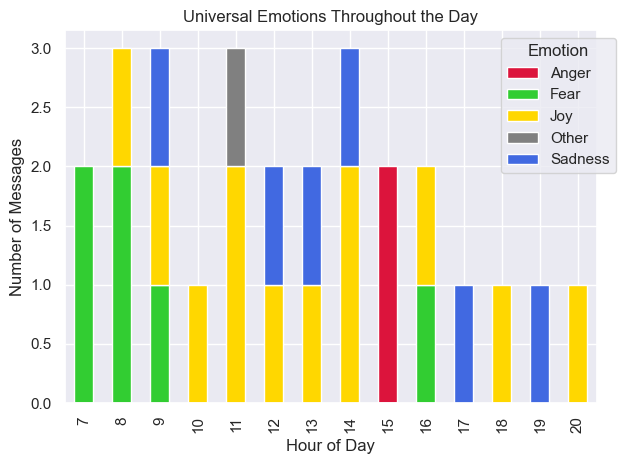

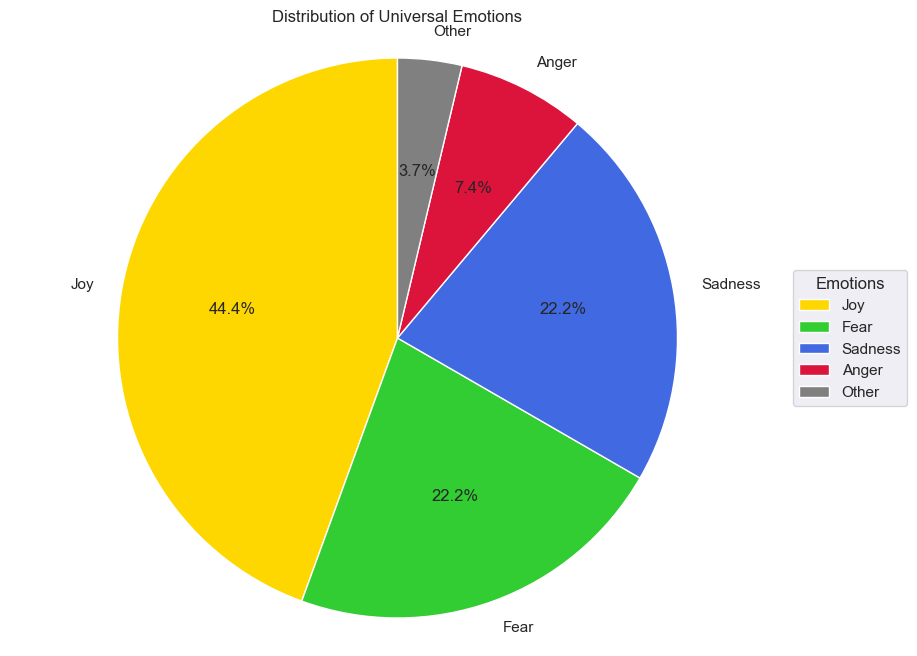


Peak Times for Universal Emotions:
------------------------------
Anger: 15:00 hours (2 messages)
Fear: 7:00 hours (2 messages)
Joy: 11:00 hours (2 messages)
Sadness: 9:00 hours (1 messages)


In [5]:
# Create visualization for universal emotions throughout the day
plt.figure(figsize=(12, 6))

# Create emotion distribution by hour
emotion_by_hour = pd.crosstab(df['hour'], df['universal_emotion'])

# Define colors for each universal emotion
emotion_colors = {
    'Joy': '#FFD700',      # Gold
    'Sadness': '#4169E1',  # Royal Blue
    'Fear': '#32CD32',     # Lime Green
    'Anger': '#DC143C',    # Crimson
    'Disgust': '#800080'   # Purple
}

# Plot with specific colors
emotion_by_hour.plot(kind='bar', stacked=True, 
                    color=[emotion_colors.get(emotion, '#808080') for emotion in emotion_by_hour.columns])
plt.title('Universal Emotions Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Create a pie chart of overall emotion distribution
plt.figure(figsize=(10, 8))
emotion_counts = df['universal_emotion'].value_counts()

# Plot pie chart
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
        colors=[emotion_colors.get(emotion, '#808080') for emotion in emotion_counts.index],
        startangle=90)
plt.title('Distribution of Universal Emotions')

# Add a legend
plt.legend(title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.show()

# Display peak times for each universal emotion
print("\nPeak Times for Universal Emotions:")
print("-" * 30)
for emotion in emotion_by_hour.columns:
    if emotion != 'Other':
        peak_hour = emotion_by_hour[emotion].idxmax()
        count = emotion_by_hour[emotion][peak_hour]
        print(f"{emotion}: {peak_hour}:00 hours ({count} messages)")

## Daily Emotional Patterns Analysis

Let's analyze how emotions vary throughout the day and week:

<Figure size 1200x600 with 0 Axes>

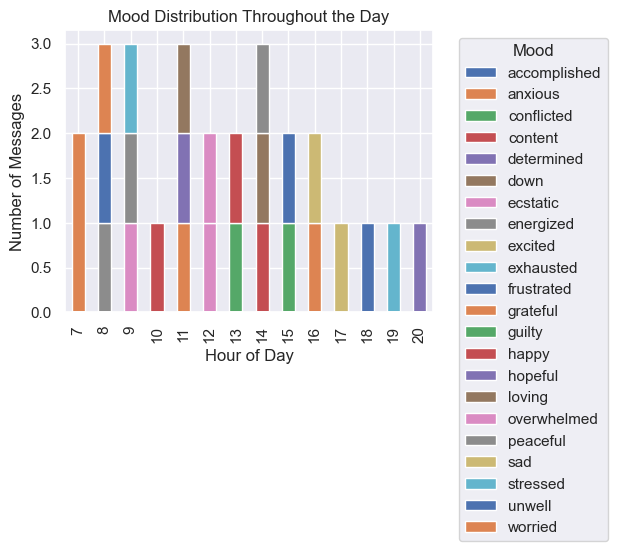


Peak Times for Different Moods:
------------------------------
anxious: 7:00 hours
stressed: 9:00 hours
overwhelmed: 9:00 hours
frustrated: 15:00 hours
exhausted: 19:00 hours
energized: 8:00 hours
grateful: 11:00 hours
down: 14:00 hours
sad: 17:00 hours
happy: 10:00 hours
guilty: 13:00 hours
excited: 16:00 hours
unwell: 8:00 hours
loving: 11:00 hours
peaceful: 9:00 hours
accomplished: 18:00 hours
ecstatic: 12:00 hours
conflicted: 15:00 hours
worried: 8:00 hours
hopeful: 11:00 hours
content: 14:00 hours
determined: 20:00 hours


In [3]:
# Extract hour and day from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# Create mood distribution by hour
plt.figure(figsize=(12, 6))
mood_by_hour = pd.crosstab(df['hour'], df['mood_logged'])
mood_by_hour.plot(kind='bar', stacked=True)
plt.title('Mood Distribution Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='Mood', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Print peak times for different moods
print("\nPeak Times for Different Moods:")
print("-" * 30)
for mood in df['mood_logged'].unique():
    peak_hour = mood_by_hour[mood].idxmax()
    print(f"{mood}: {peak_hour}:00 hours")

<Figure size 1200x600 with 0 Axes>

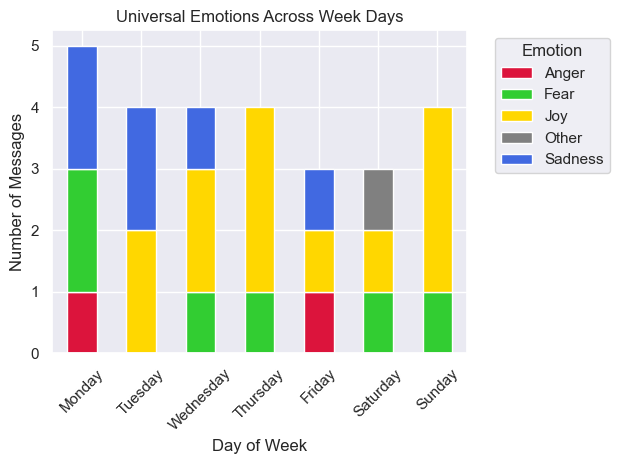


Dominant Emotion by Day:
------------------------------
Monday: Fear (40.0% of messages)
Tuesday: Joy (50.0% of messages)
Wednesday: Joy (50.0% of messages)
Thursday: Joy (75.0% of messages)
Friday: Anger (33.3% of messages)
Saturday: Fear (33.3% of messages)
Sunday: Joy (75.0% of messages)

Emotional Balance by Day:
------------------------------

Monday:
  Anger: 20.0%
  Fear: 40.0%
  Joy: 0.0%
  Sadness: 40.0%

Tuesday:
  Anger: 0.0%
  Fear: 0.0%
  Joy: 50.0%
  Sadness: 50.0%

Wednesday:
  Anger: 0.0%
  Fear: 25.0%
  Joy: 50.0%
  Sadness: 25.0%

Thursday:
  Anger: 0.0%
  Fear: 25.0%
  Joy: 75.0%
  Sadness: 0.0%

Friday:
  Anger: 33.3%
  Fear: 0.0%
  Joy: 33.3%
  Sadness: 33.3%

Saturday:
  Anger: 0.0%
  Fear: 33.3%
  Joy: 33.3%
  Sadness: 0.0%

Sunday:
  Anger: 0.0%
  Fear: 25.0%
  Joy: 75.0%
  Sadness: 0.0%


In [6]:
# Create emotion distribution by day of week
plt.figure(figsize=(12, 6))
emotion_by_day = pd.crosstab(df['day_of_week'], df['universal_emotion'])

# Reorder days of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
emotion_by_day = emotion_by_day.reindex(days_order)

# Define colors for each universal emotion
emotion_colors = {
    'Joy': '#FFD700',      # Gold
    'Sadness': '#4169E1',  # Royal Blue
    'Fear': '#32CD32',     # Lime Green
    'Anger': '#DC143C',    # Crimson
    'Disgust': '#800080'   # Purple
}

# Plot with specific colors
emotion_by_day.plot(kind='bar', stacked=True,
                   color=[emotion_colors.get(emotion, '#808080') for emotion in emotion_by_day.columns])
plt.title('Universal Emotions Across Week Days')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and display the dominant emotion for each day
print("\nDominant Emotion by Day:")
print("-" * 30)
for day in days_order:
    if day in emotion_by_day.index:
        dominant_emotion = emotion_by_day.loc[day].idxmax()
        count = emotion_by_day.loc[day][dominant_emotion]
        total = emotion_by_day.loc[day].sum()
        percentage = (count / total) * 100
        print(f"{day}: {dominant_emotion} ({percentage:.1f}% of messages)")

# Calculate emotional balance for each day
print("\nEmotional Balance by Day:")
print("-" * 30)
for day in days_order:
    if day in emotion_by_day.index:
        day_total = emotion_by_day.loc[day].sum()
        print(f"\n{day}:")
        for emotion in emotion_by_day.columns:
            if emotion != 'Other':
                count = emotion_by_day.loc[day].get(emotion, 0)
                percentage = (count / day_total) * 100
                print(f"  {emotion}: {percentage:.1f}%")